In [75]:
import pandas as pd
import numpy as np

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

Загрузка данных

In [6]:
airlines_passengers = pd.read_csv("D:\\GitRepo\\Нетология\\Временные ряды\\1._Лекция\\Series\\international-airline-passengers.csv")
female_births = pd.read_csv("D:\\GitRepo\\Нетология\\Временные ряды\\1._Лекция\\Series\\daily-total-female-births-in-cal.csv")

In [7]:
all_series = {
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Daily total female births in California": female_births["Count"]
}

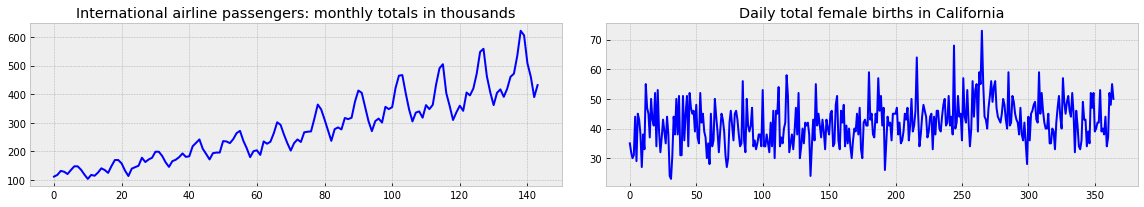

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

Проверяем тестом дики-фуллера стационарность рядов

In [9]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput['p-value'])

In [10]:
for key in all_series.keys():
    print('-----',key,':')
    test_stationarity(all_series[key])

----- International airline passengers: monthly totals in thousands :
Results of Dickey-Fuller Test:
0.9918802434376411
----- Daily total female births in California :
Results of Dickey-Fuller Test:
5.243412990149989e-05


Второй ряд уже стационарен, поэтому приблизим его экспоненциальным скользящим средним. Изначально стационарный ряд как правило сильно зашумлен, а значит самое главное в модели - предсказать тренд. Если задать достаточно маленькую сглаживающую константу, то мы получим неплохой тренд уже без такой сильной зашумленности.

In [60]:
train, test = all_series["Daily total female births in California"][:350], all_series["Daily total female births in California"][350:]

In [61]:
def exponential_moving_average(series, alpha, L):
    result = [series[0]]
    for n in range(1, len(series)+L):
        if n < len(series):
            result.append(alpha * series[n] + (1 - alpha) * result[n-1])
        else:
            result.append(alpha * result[n-1] + (1 - alpha) * result[n-2])
    return pd.Series(result)

Mean squared_error: 40.18046920830518


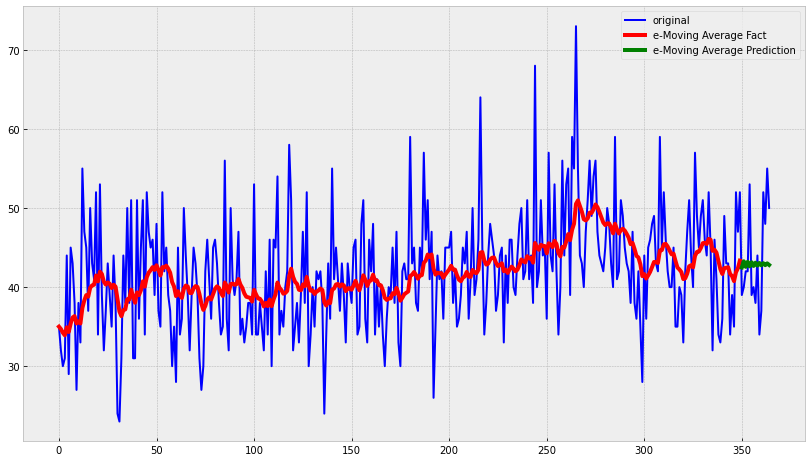

In [64]:
ts = train
ser =  exponential_moving_average(ts, 0.1, len(test))
fact = ser[:350]
pred = ser[350:]
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series["Daily total female births in California"], color='blue',label='original')
    plt.plot(fact, color='red', linewidth='4', label='e-Moving Average Fact')
    plt.plot(pred, color='green', linewidth='4', label='e-Moving Average Prediction')
    plt.legend()
print('Mean squared_error:',mean_squared_error(test, pred))

Вернемся к ряду International airline passengers: monthly totals in thousands. Этот ряд имеет сезонность и тренд, поэтому будем использовать метод Хольта-Винтерса, предварительно сделав преобразование бокса-кокса.

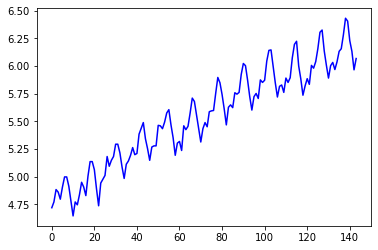

In [101]:
series = all_series["International airline passengers: monthly totals in thousands"] 
series = boxcox(series, 0)
plt.plot(series, color='blue')

In [102]:
train, test = series[:120], series[120:]

In [136]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

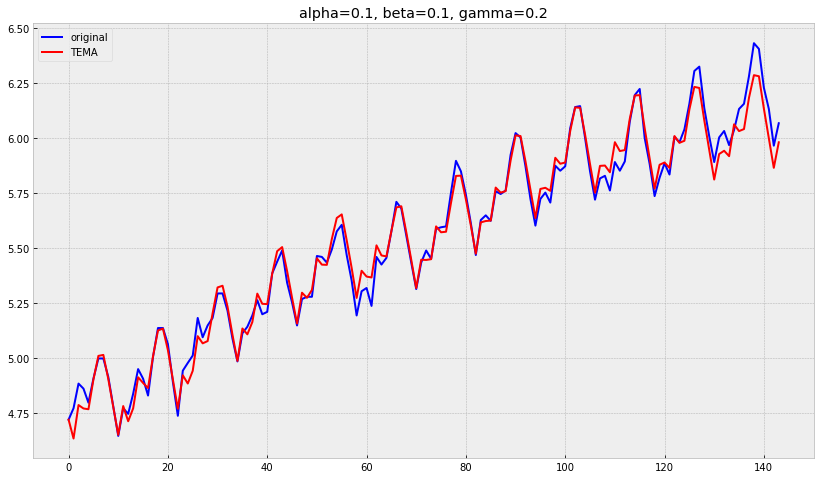

In [143]:
plot_tema(0.1, 0.1, 0.2, train, series, len(test))

Подберем параметры, используя кросс-валидацию

In [144]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    for train_split, test_split in split.split(train):
        train_split_ts = train[train_split]
        test_split_ts = train[test_split]

        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    return np.mean(np.array(errors))

In [145]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [146]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.004193117758070008
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.82253127e-08, -2.49539972e-07, -5.76929474e-04])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 144
      nit: 29
     njev: 36
   status: 0
  success: True
        x: array([0.38685937, 0.04340718, 1.        ])


Mean squared_error: 0.004193117758070008


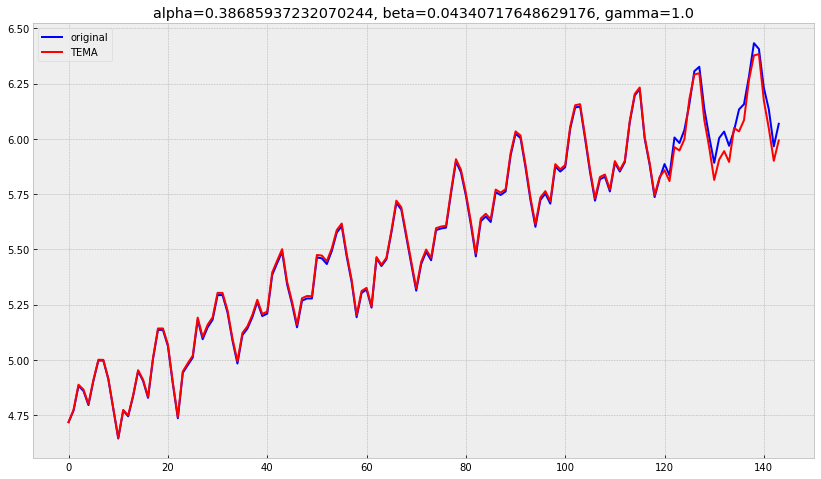

In [147]:
plot_tema(alpha_opt, beta_opt, gamma_opt, train, series, len(test))
print('Mean squared_error:',mse_cross_val((alpha_opt, beta_opt, gamma_opt)))

Прогноз получился вполне  приличный!